In [1]:
!mkdir -p /data/tusimple
!wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/1/train_set.zip
!unzip train_set.zip -d /data/tusimple

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /data/tusimple/clips/0313-1/24060/19.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/18.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/17.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/16.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/15.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/14.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/13.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/12.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/11.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/10.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/9.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/8.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/7.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/6.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/5.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/4.jpg  
  inflating: /data/tusimple/clips/0313-1/2

In [2]:
import torch
import os
import os.path as ops
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as transforms
from tqdm import tqdm
import torch.nn.functional as F
import torchvision
import pdb
import glob
import shutil
import time
from torch.autograd import Variable
import random
from sklearn.cluster import DBSCAN
import albumentations as A

In [3]:
#@title
def get_image_to_folders(json_label_path, gt_image_dir, gt_binary_dir, gt_instance_dir, src_dir, target_dir):
    image_nums = len(os.listdir(gt_image_dir))
    with open(json_label_path, 'r') as file:
        print('Process {:s}'.format(json_label_path))
        for line_index, line in enumerate(file):
            info_dict = json.loads(line)
            raw_file = info_dict['raw_file']
            h_samples = info_dict['h_samples']
            lanes = info_dict['lanes']

            image_path = ops.join(src_dir, raw_file)
            image_name_new = '{:s}.png'.format('{:d}'.format(line_index + image_nums).zfill(4))
            image_output_path = ops.join(ops.split(target_dir)[0], 'gt_image', image_name_new)
            binary_output_path = ops.join(ops.split(target_dir)[0], 'gt_binary_image', image_name_new)
            instance_output_path = ops.join(ops.split(target_dir)[0], 'gt_instance_image', image_name_new)

            src_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            dst_binary_image = np.zeros([src_image.shape[0], src_image.shape[1]], np.uint8)
            dst_instance_image = np.zeros([src_image.shape[0], src_image.shape[1]], np.uint8)

            for lane_index, lane in enumerate(lanes):
                assert len(h_samples) == len(lane)
                lane_x = []
                lane_y = []
                for index in range(len(lane)):
                    if lane[index] == -2:
                        continue
                    else:
                        ptx = lane[index]
                        pty = h_samples[index]
                        lane_x.append(ptx)
                        lane_y.append(pty)
                if not lane_x:
                    continue
                lane_pts = np.vstack((lane_x, lane_y)).transpose()
                lane_pts = np.array([lane_pts], np.int64)

                cv2.polylines(dst_binary_image, lane_pts, isClosed=False, color=255, thickness=5)
                cv2.polylines(dst_instance_image, lane_pts, isClosed=False, color=lane_index * 50 + 20, thickness=5)

            cv2.imwrite(binary_output_path, dst_binary_image)
            cv2.imwrite(instance_output_path, dst_instance_image)
            cv2.imwrite(image_output_path, src_image)
        print('Process {:s} success'.format(json_label_path))


def gen_train_sample(target_dir, b_gt_image_dir, i_gt_image_dir, image_dir):
    os.makedirs('{:s}'.format(ops.split(target_dir)[0]), exist_ok=True)
    with open('{:s}/train.txt'.format(ops.split(target_dir)[0]), 'w') as file:
        for image_name in os.listdir(b_gt_image_dir):
            if not image_name.endswith('.png'):
                continue
            binary_gt_image_path = ops.join(b_gt_image_dir, image_name)
            instance_gt_image_path = ops.join(i_gt_image_dir, image_name)
            image_path = ops.join(image_dir, image_name)

            b_gt_image = cv2.imread(binary_gt_image_path, cv2.IMREAD_COLOR)
            i_gt_image = cv2.imread(instance_gt_image_path, cv2.IMREAD_COLOR)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)

            if b_gt_image is None or image is None or i_gt_image is None:
                print('Image set: {:s} broken'.format(image_name))
                continue
            else:
                info = '{:s} {:s} {:s}'.format(image_path, binary_gt_image_path, instance_gt_image_path)
                file.write(info + '\n')


def split_train_txt(target_dir):
    train_file_path =  '{:s}/train.txt'.format(ops.split(target_dir)[0])
    val_file_path = '{:s}/val.txt'.format(ops.split(target_dir)[0])
    with open(train_file_path, 'r') as file:
        data = file.readlines()
        train_data = data[:int(len(data)*0.8)]
        val_data = data[int(len(data)*0.8):]
    with open(train_file_path, 'w') as file:
        for d in train_data:
            file.write(d)
    with open(val_file_path, 'w') as file:
        for d in val_data:
            file.write(d)


def process_tusimple_dataset(src_dir, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    gt_image_dir = ops.join(target_dir, 'gt_image')
    gt_binary_dir = ops.join(target_dir, 'gt_binary_image')
    gt_instance_dir = ops.join(target_dir, 'gt_instance_image')
    os.makedirs(gt_image_dir, exist_ok=True)
    os.makedirs(gt_binary_dir, exist_ok=True)
    os.makedirs(gt_instance_dir, exist_ok=True)
    for json_label_path in glob.glob('{:s}/*.json'.format(src_dir)):
        get_image_to_folders(json_label_path, gt_image_dir, gt_binary_dir, gt_instance_dir, src_dir, target_dir)
    gen_train_sample(target_dir, gt_binary_dir, gt_instance_dir, gt_image_dir)
    split_train_txt(target_dir)

In [4]:
src_dir = '/data/tusimple/'
target_dir = '/data/tusimple_prepared/'
process_tusimple_dataset(src_dir, target_dir)

Process /data/tusimple/label_data_0531.json
Process /data/tusimple/label_data_0531.json success
Process /data/tusimple/label_data_0601.json
Process /data/tusimple/label_data_0601.json success
Process /data/tusimple/label_data_0313.json
Process /data/tusimple/label_data_0313.json success


In [3]:
from google.colab import drive
drive.mount('/content/drive')
#!cp -r /data/tusimple_prepared/ /content/drive/MyDrive/ --recursive

Mounted at /content/drive


In [6]:
DEFAULT_SIZE = (256, 512)

class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=True, size=DEFAULT_SIZE):
        self.dataset_path = dataset_path
        self.size = size
        self.train = train
        self.img_paths = []
        self.train_file = ops.join(dataset_path, 'train.txt')
        self.val_file = ops.join(dataset_path, 'val.txt')
        if self.train:
            file_open = self.train_file
        else:
            file_open = self.val_file
        with open(file_open, 'r') as file:
            data = file.readlines()
            for l in data:
                line = l.split()
                self.img_paths.append(line)

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        new_size = (self.size[1], self.size[0])
        gt_image = cv2.imread(self.img_paths[idx][0], cv2.IMREAD_UNCHANGED)
        gt_binary_image = cv2.imread(self.img_paths[idx][1], cv2.IMREAD_UNCHANGED)
        gt_instance = cv2.imread(self.img_paths[idx][2], cv2.IMREAD_UNCHANGED)

        gt_image = cv2.resize(gt_image, dsize=new_size, interpolation=cv2.INTER_LINEAR)
        gt_binary_image = cv2.resize(gt_binary_image, dsize=new_size, interpolation=cv2.INTER_NEAREST)
        gt_instance = cv2.resize(gt_instance, dsize=new_size, interpolation=cv2.INTER_NEAREST)

        #gt_image = gt_image / 127.5 - 1.0
        gt_binary_image = np.array(gt_binary_image / 255.0, dtype=np.uint8)
        gt_binary_image = gt_binary_image[:, :, np.newaxis]
        gt_instance = gt_instance[:, :, np.newaxis]

        gt_image = np.transpose(gt_image, (2, 0, 1))
        gt_binary_image = np.transpose(gt_binary_image, (2, 0, 1))
        gt_instance = np.transpose(gt_instance, (2, 0, 1))

        gt_image = torch.tensor(gt_image, dtype=torch.float)
        # trsf = torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), inplace=False)
        # gt_image = trsf(gt_image)
        gt_binary_image = torch.tensor(gt_binary_image, dtype=torch.long).squeeze()
        #.view(self.size[1], self.size[0])
        #gt_binary_image = torch.tensor(gt_binary_image, dtype=torch.float)
        # gt_instance = torch.tensor(gt_instance, dtype=torch.float)
        gt_instance = torch.tensor(gt_instance, dtype=torch.long).squeeze()
        #view(self.size[0], self.size[1])

        return gt_image, gt_binary_image, gt_instance
        #return image, segmentation_image, instance_image # 1 x H x W [[0, 1], [2, 0]]

In [7]:
# Directory of train, val .txt files
dataset_path = '/data/tusimple_prepared/'
#google drive
#dataset_path = '/content/drive/MyDrive/tusimple_prepared/'

# Build train, valid, test set
train_set = LaneDataset(dataset_path, train=True)
val_set = LaneDataset(dataset_path, train=False)

# Print the number of samples of each set
print('train_set length {}'.format(len(train_set)))
print('val_set length {} \n'.format(len(val_set)))

train_set length 2900
val_set length 726 



idx: 1268


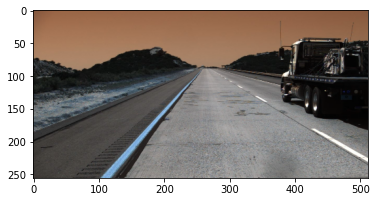

image type <class 'torch.Tensor'>
image size torch.Size([3, 256, 512])


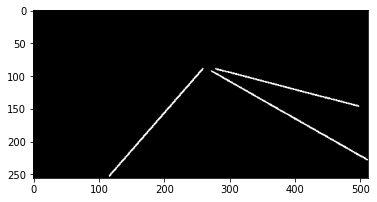

gt binary image type <class 'torch.Tensor'>
gt binary image size torch.Size([256, 512])
items in gt binary image tensor([0, 1]) 



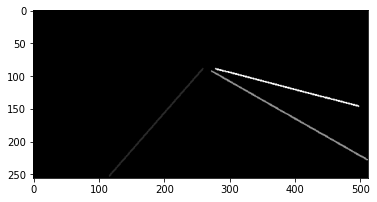

gt instance type <class 'torch.Tensor'>
gt instance size torch.Size([256, 512])
items in gt instance tensor([  0,  20,  70, 120]) 



In [8]:
# Choice a random index to get the corresponding sample image, binary lane image, instance lane image
idx = random.randint(0, len(train_set))
print('idx:', idx)
gt, bgt, igt = train_set[idx]

plt.imshow(np.transpose(gt, (1, 2, 0)).numpy().astype(int))
plt.show()
print('image type {}'.format(type(gt)))
print('image size {}'.format(gt.size()))

plt.imshow(bgt.numpy(), cmap='gray')
plt.show()
print('gt binary image type {}'.format(type(bgt)))
print('gt binary image size {}'.format(bgt.size()))
print('items in gt binary image {} \n'.format(torch.unique(bgt)))

plt.imshow(igt.numpy(), cmap='gray')
plt.show()
print('gt instance type {}'.format(type(igt)))
print('gt instance size {}'.format(igt.size()))
print('items in gt instance {} \n'.format(torch.unique(igt)))

In [9]:
#@title
class InitialBlock(nn.Module):
    """The initial block is composed of two branches:
    1. a main branch which performs a regular convolution with stride 2;
    2. an extension branch which performs max-pooling.
    Doing both operations in parallel and concatenating their results
    allows for efficient downsampling and expansion. The main branch
    outputs 13 feature maps while the extension branch outputs 3, for a
    total of 16 feature maps after concatenation.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number output channels.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 3,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)


class RegularBottleneck(nn.Module):
    """Regular bottlenecks are the main building block of ENet.
    Main branch:
    1. Shortcut connection.
    Extension branch:
    1. 1x1 convolution which decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. regular, dilated or asymmetric convolution;
    3. 1x1 convolution which increases the number of channels back to
    ``channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - channels (int): the number of input and output channels.
    - internal_ratio (int, optional): a scale factor applied to
    ``channels`` used to compute the number of
    channels after the projection. eg. given ``channels`` equal to 128 and
    internal_ratio equal to 2 the number of channels after the projection
    is 64. Default: 4.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer described above in item 2 of the extension
    branch. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - dilation (int, optional): spacing between kernel elements for the
    convolution described in item 2 of the extension branch. Default: 1.
    asymmetric (bool, optional): flags if the convolution described in
    item 2 of the extension branch is asymmetric or not. Default: False.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class DownsamplingBottleneck(nn.Module):
    """Downsampling bottlenecks further downsample the feature map size.
    Main branch:
    1. max pooling with stride 2; indices are saved to be used for
    unpooling later.
    Extension branch:
    1. 2x2 convolution with stride 2 that decreases the number of channels
    by ``internal_ratio``, also called a projection;
    2. regular convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``channels``
    used to compute the number of channels after the projection. eg. given
    ``channels`` equal to 128 and internal_ratio equal to 2 the number of
    channels after the projection is 64. Default: 4.
    - return_indices (bool, optional):  if ``True``, will return the max
    indices along with the outputs. Useful when unpooling later.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices


class UpsamplingBottleneck(nn.Module):
    """The upsampling bottlenecks upsample the feature map resolution using max
    pooling indices stored from the corresponding downsampling bottleneck.
    Main branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. max unpool layer using the max pool indices from the corresponding
    downsampling max pool layer.
    Extension branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. transposed convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``in_channels``
     used to compute the number of channels after the projection. eg. given
     ``in_channels`` equal to 128 and ``internal_ratio`` equal to 2 the number
     of channels after the projection is 64. Default: 4.
    - dropout_prob (float, optional): probability of an element to be zeroed.
    Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if ``True``.
    Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


#class Lanenet(nn.Module):
class ENet(nn.Module):
    #def __init__(self):
    def __init__(self, binary_seg, embedding_dim, encoder_relu=False, decoder_relu=True):
        #super(Lanenet, self).__init__()
        super(ENet, self).__init__()

        self.initial_block = InitialBlock(3, 16, relu=encoder_relu)

        # Stage 1 share
        self.downsample1_0 = DownsamplingBottleneck(16, 64, return_indices=True, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 share
        self.downsample2_0 = DownsamplingBottleneck(64, 128, return_indices=True, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 binary
        self.regular_binary_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_binary_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 embedding
        self.regular_embedding_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_embedding_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_embedding_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_bembedding_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # binary branch
        self.upsample_binary_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_binary_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.binary_transposed_conv = nn.ConvTranspose2d(16, binary_seg, kernel_size=3, stride=2, padding=1, bias=False)

        # embedding branch
        self.upsample_embedding_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_embedding_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.embedding_transposed_conv = nn.ConvTranspose2d(16, embedding_dim, kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 share
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 share
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # stage 3 binary
        x_binary = self.regular_binary_3_0(x)
        x_binary = self.dilated_binary_3_1(x_binary)
        x_binary = self.asymmetric_binary_3_2(x_binary)
        x_binary = self.dilated_binary_3_3(x_binary)
        x_binary = self.regular_binary_3_4(x_binary)
        x_binary = self.dilated_binary_3_5(x_binary)
        x_binary = self.asymmetric_binary_3_6(x_binary)
        x_binary = self.dilated_binary_3_7(x_binary)

        # stage 3 embedding
        x_embedding = self.regular_embedding_3_0(x)
        x_embedding = self.dilated_embedding_3_1(x_embedding)
        x_embedding = self.asymmetric_embedding_3_2(x_embedding)
        x_embedding = self.dilated_embedding_3_3(x_embedding)
        x_embedding = self.regular_embedding_3_4(x_embedding)
        x_embedding = self.dilated_embedding_3_5(x_embedding)
        x_embedding = self.asymmetric_bembedding_3_6(x_embedding)
        x_embedding = self.dilated_embedding_3_7(x_embedding)

        # binary branch
        x_binary = self.upsample_binary_4_0(x_binary, max_indices2_0, output_size=stage2_input_size)
        x_binary = self.regular_binary_4_1(x_binary)
        x_binary = self.regular_binary_4_2(x_binary)
        x_binary = self.upsample_binary_5_0(x_binary, max_indices1_0, output_size=stage1_input_size)
        x_binary = self.regular_binary_5_1(x_binary)
        binary_final_logits = self.binary_transposed_conv(x_binary, output_size=input_size)

        # embedding branch
        x_embedding = self.upsample_embedding_4_0(x_embedding, max_indices2_0, output_size=stage2_input_size)
        x_embedding = self.regular_embedding_4_1(x_embedding)
        x_embedding = self.regular_embedding_4_2(x_embedding)
        x_embedding = self.upsample_embedding_5_0(x_embedding, max_indices1_0, output_size=stage1_input_size)
        x_embedding = self.regular_embedding_5_1(x_embedding)
        instance_notfinal_logits = self.embedding_transposed_conv(x_embedding, output_size=input_size)

        return binary_final_logits, instance_notfinal_logits

In [10]:
test_input = torch.ones((8, 3, 256, 512))
net = ENet(2, 5)
binary_final_logits, instance_notfinal_logits = net(test_input)
print(binary_final_logits.shape)
print(instance_notfinal_logits.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([8, 2, 256, 512])
torch.Size([8, 5, 256, 512])


In [11]:
#@title
class DiscriminativeLoss(torch.nn.modules.loss._Loss):
    def __init__(self, delta_var=0.5, delta_dist=1.5, norm=2, alpha=1.0, beta=1.0, gamma=0.001,
                 size_average=True):
        super(DiscriminativeLoss, self).__init__(reduction='mean')
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        assert self.norm in [1, 2]

    def forward(self, input, target):
        return self._discriminative_loss(input, target)

    def _discriminative_loss(self, embedding, seg_gt):
        batch_size, embed_dim, H, W = embedding.shape
        embedding = embedding.reshape(batch_size, embed_dim, H*W)
        seg_gt = seg_gt.reshape(batch_size, H*W)

        var_loss = torch.tensor(0, dtype=embedding.dtype, device=embedding.device)
        dist_loss = torch.tensor(0, dtype=embedding.dtype, device=embedding.device)
        reg_loss = torch.tensor(0, dtype=embedding.dtype, device=embedding.device)

        for b in range(batch_size):
            embedding_b = embedding[b]  # (embed_dim, H*W)
            seg_gt_b = seg_gt[b]  # (H*W)

            labels, indexs = torch.unique(seg_gt_b, return_inverse=True)
            num_lanes = len(labels)
            if num_lanes == 0:
                _nonsense = embedding.sum()
                _zero = torch.zeros_like(_nonsense)
                var_loss = var_loss + _nonsense * _zero
                dist_loss = dist_loss + _nonsense * _zero
                reg_loss = reg_loss + _nonsense * _zero
                continue

            centroid_mean = []
            for lane_idx in labels:
                seg_mask_i = (seg_gt_b == lane_idx)

                if not seg_mask_i.any():
                    continue
                
                embedding_i = embedding_b * seg_mask_i
                mean_i = torch.sum(embedding_i, dim=1) / torch.sum(seg_mask_i)
                centroid_mean.append(mean_i)
                # ---------- var_loss -------------
                var_loss = var_loss + torch.sum(F.relu(
                    torch.norm(embedding_i[:,seg_mask_i] - mean_i.reshape(embed_dim, 1), dim=0) - self.delta_var) ** 2) / torch.sum(seg_mask_i) / num_lanes
            centroid_mean = torch.stack(centroid_mean)  # (n_lane, embed_dim)

            if num_lanes > 1:
                centroid_mean1 = centroid_mean.reshape(-1, 1, embed_dim)
                centroid_mean2 = centroid_mean.reshape(1, -1, embed_dim)

                dist = torch.norm(centroid_mean1 - centroid_mean2, dim=2)   # shape (num_lanes, num_lanes)
                dist = dist + torch.eye(num_lanes, dtype=dist.dtype,
                                        device=dist.device) * self.delta_dist

                # divided by two for double calculated loss above, for implementation convenience
                dist_loss = dist_loss + torch.sum(F.relu(-dist + self.delta_dist) ** 2) / (
                        num_lanes * (num_lanes - 1)) / 2

            # reg_loss is not used in original paper
            # reg_loss = reg_loss + torch.mean(torch.norm(centroid_mean, dim=1))

        var_loss = var_loss / batch_size
        dist_loss = dist_loss / batch_size
        reg_loss = reg_loss / batch_size

        return var_loss, dist_loss, reg_loss

In [12]:
# Define the batch size
batch_size = 8

# Define DataLoaders
data_loader_train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
data_loader_val = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True, num_workers=0)

# Define the learning rate
learning_rate = 5e-4

# Use GPU if available, else use CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [13]:
# Define the model
ENet_model = ENet(2, 5)
ENet_model.to(device)

# Define the optimizer
params = [p for p in ENet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=0.0002)

# Define scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Define number of epochs
num_epochs = 30

# Define the loss function
ce_loss_fn = nn.CrossEntropyLoss()
ds_loss_fn = DiscriminativeLoss()

# Define a list to append the losses 
loss_all = []

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0 Iteration 0 Binary Segmentation Loss: 1.0290601253509521 Instance Segmentation Loss: 1.7224622964859009 
Epoch 0 Iteration 20 Binary Segmentation Loss: 0.6879759430885315 Instance Segmentation Loss: 1.1255675554275513 
Epoch 0 Iteration 40 Binary Segmentation Loss: 0.5532150864601135 Instance Segmentation Loss: 0.9589442014694214 
Epoch 0 Iteration 60 Binary Segmentation Loss: 0.41833698749542236 Instance Segmentation Loss: 0.48687365651130676 
Epoch 0 Iteration 80 Binary Segmentation Loss: 0.3002721667289734 Instance Segmentation Loss: 0.3599597215652466 
Epoch 0 Iteration 100 Binary Segmentation Loss: 0.2424372285604477 Instance Segmentation Loss: 0.29782187938690186 
Epoch 0 Iteration 120 Binary Segmentation Loss: 0.180770605802536 Instance Segmentation Loss: 0.2361098974943161 
Epoch 0 Iteration 140 Binary Segmentation Loss: 0.15915615856647491 Instance Segmentation Loss: 0.21699702739715576 
Epoch 0 Iteration 160 Binary Segmentation Loss: 0.12642338871955872 Instance Segme

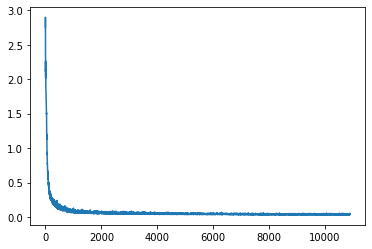

In [25]:
# Let's train the model
for epoch in range(num_epochs):
    ENet_model.train()
    ts = time.time()
    for iter, batch in enumerate(data_loader_train):
        input_image = Variable(batch[0]).to(device)
        binary_labels = Variable(batch[1]).to(device)
        instance_labels = Variable(batch[2]).to(device)
        
        binary_final_logits, instance_embedding = ENet_model(input_image)

        binary_segmenatation_loss = ce_loss_fn(binary_final_logits, binary_labels)
        var_loss, dist_loss, reg_loss = ds_loss_fn(instance_embedding, instance_labels)   
        instance_segmenatation_loss = 1* var_loss + 1 * dist_loss + 0.001 * reg_loss
        #instance_segmenatation_loss = ds_loss_fn(instance_embedding, instance_labels)
        loss = 1 * binary_segmenatation_loss + 1 * instance_segmenatation_loss

        optimizer.zero_grad()
        loss_all.append(loss.item())
        loss.backward()
        optimizer.step()
        
        if iter % 20 == 0:
            print("Epoch {} Iteration {} Binary Segmentation Loss: {} Instance Segmentation Loss: {} ".format(epoch, iter, binary_segmenatation_loss.item(), instance_segmenatation_loss.item()))
    lr_scheduler.step()
    print("Epoch {} finished! Time elapsed {} ".format(epoch, time.time() - ts))
    torch.save(ENet_model.state_dict(), f"/data/tusimple/lanenet_epoch_{epoch}_batch_size_{batch_size}.model")

    """
    val_loss_all = []
    ENet_model.eval()
    with torch.no_grad():
        for iter, batch in enumerate(data_loader_val):
            input_image = Variable(batch[0]).to(device)
            binary_labels = Variable(batch[1]).to(device)
            instance_labels = Variable(batch[2]).to(device)
            
            binary_final_logits, instance_embedding = ENet_model(input_image)

            binary_segmenatation_loss = ce_loss_fn(binary_final_logits, binary_labels)
            var_loss, dist_loss, reg_loss = ds_loss_fn(instance_embedding, instance_labels)   
            instance_segmenatation_loss = 1* var_loss + 1 * dist_loss + 0.001 * reg_loss
            #instance_segmenatation_loss = ds_loss_fn(instance_embedding, instance_labels)
            loss = 1 * binary_segmenatation_loss + 1 * instance_segmenatation_loss

            
            val_loss_all.append(loss.item())
            
            if iter % 100 == 0:
                print("Validation: Epoch {} Iteration {} Binary Segmentation Loss: {} Instance Segmentation Loss: {} ".format(epoch, iter, binary_segmenatation_loss.item(), instance_segmenatation_loss.item()))
"""

# Plot the loss
import matplotlib.pylab as plt
plt.plot(loss_all)

In [26]:
#@title
!cp /data/tusimple/lanenet_epoch_0_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_1_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_2_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_3_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_4_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_5_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_6_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_7_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_8_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_9_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_10_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_11_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_12_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_13_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_14_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_15_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_16_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_17_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_18_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_19_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_20_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_21_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_22_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_23_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_24_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_25_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_26_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_27_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_28_batch_size_8.model /content/drive/MyDrive/
!cp /data/tusimple/lanenet_epoch_29_batch_size_8.model /content/drive/MyDrive/

In [27]:
val_loss_all = []
ENet_model.eval()
with torch.no_grad():
    for iter, batch in enumerate(data_loader_val):
        input_image = Variable(batch[0]).to(device)
        binary_labels = Variable(batch[1]).to(device)
        instance_labels = Variable(batch[2]).to(device)
        
        binary_final_logits, instance_embedding = ENet_model(input_image)

        binary_segmenatation_loss = ce_loss_fn(binary_final_logits, binary_labels)
        var_loss, dist_loss, reg_loss = ds_loss_fn(instance_embedding, instance_labels)   
        instance_segmenatation_loss = 1* var_loss + 1 * dist_loss + 0.001 * reg_loss
        #instance_segmenatation_loss = ds_loss_fn(instance_embedding, instance_labels)
        loss = 1 * binary_segmenatation_loss + 1 * instance_segmenatation_loss

        
        val_loss_all.append(loss.item())
        
print("Validation Loss: {}".format(sum(val_loss_all) / len(val_loss_all)))

Validation Loss: 0.04607277933364483


In [14]:
lanenet_model = ENet(2, 5)
PATH= '/data/lanenet_epoch_29_batch_size_8.model'
#lanenet_model.load_state_dict(torch.load(PATH))
lanenet_model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
lanenet_model.eval()

ENet(
  (initial_block): InitialBlock(
    (main_branch): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (ext_branch): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (out_activation): PReLU(num_parameters=1)
  )
  (downsample1_0): DownsamplingBottleneck(
    (main_max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (ext_conv1): Sequential(
      (0): Conv2d(16, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (ext_conv2): Sequential(
      (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (ext_c

idx: 126


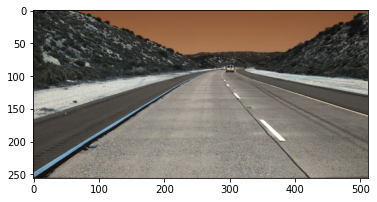

image type <class 'torch.Tensor'>
image size torch.Size([3, 256, 512])


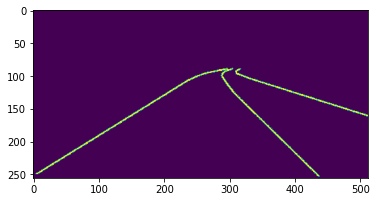

gt binary image type <class 'torch.Tensor'>
gt binary image size torch.Size([256, 512])
items in gt binary image tensor([0, 1]) 



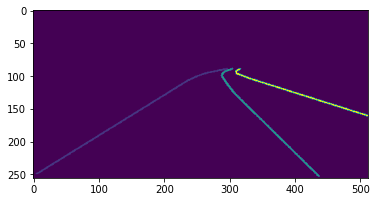

gt instance type <class 'torch.Tensor'>
gt instance size torch.Size([256, 512])
items in gt instance tensor([  0,  20,  70, 120]) 



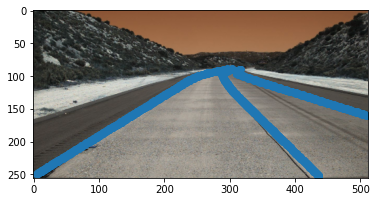

In [66]:
# Choice a random index to get the corresponding sample image, binary lane image, instance lane image
idx = random.randint(0, len(val_set))
print('idx:', idx)
gt, bgt, igt = val_set[idx]

plt.imshow(np.transpose(gt, (1, 2, 0)).numpy().astype(int))
plt.show()
print('image type {}'.format(type(gt)))
print('image size {}'.format(gt.size()))

plt.imshow(bgt.numpy())
plt.show()
print('gt binary image type {}'.format(type(bgt)))
print('gt binary image size {}'.format(bgt.size()))
print('items in gt binary image {} \n'.format(torch.unique(bgt)))

plt.imshow(igt.numpy())
plt.show()
print('gt instance type {}'.format(type(igt)))
print('gt instance size {}'.format(igt.size()))
print('items in gt instance {} \n'.format(torch.unique(igt)))

plt.imshow(np.transpose(gt, (1, 2, 0)).numpy().astype(int))
plt.scatter(np.argwhere(bgt.numpy() == 1)[:,1], np.argwhere(bgt.numpy() == 1)[:,0])
plt.show()

img = gt.unsqueeze(0)
pred_seg, pred_emb = lanenet_model(img)

pred_seg image type <class 'torch.Tensor'>
pred_seg image size torch.Size([1, 2, 256, 512])
torch.Size([256, 512])


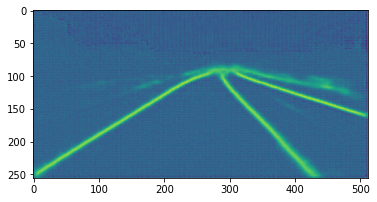

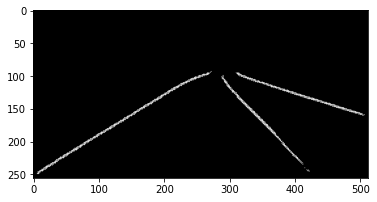

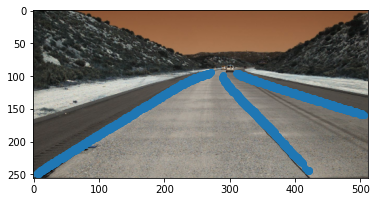

In [67]:
print('pred_seg image type {}'.format(type(pred_seg)))
print('pred_seg image size {}'.format(pred_seg.size()))

binary_mask = pred_seg.squeeze()[1]
print(binary_mask.size())
binary_mask = binary_mask.detach().numpy()
plt.imshow(binary_mask)
plt.show()
binary_mask_ = (binary_mask > 0).astype(int)
plt.imshow(binary_mask_, cmap='gray')
plt.show()
plt.imshow(np.transpose(gt, (1, 2, 0)).numpy().astype(int))
plt.scatter(np.argwhere(binary_mask_ == 1)[:,1], np.argwhere(binary_mask_ == 1)[:,0])
plt.show()

pred_emb image type <class 'torch.Tensor'>
pred_emb image size torch.Size([1, 5, 256, 512])


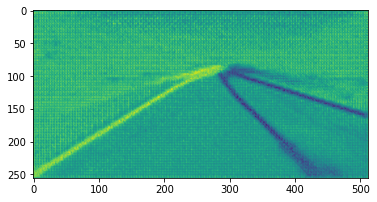

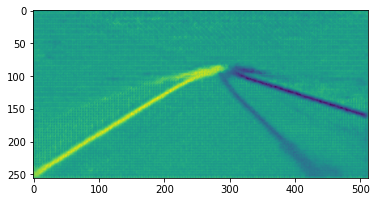

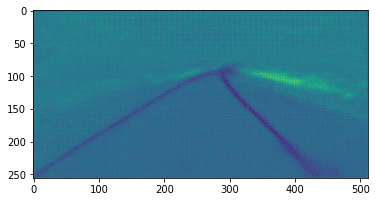

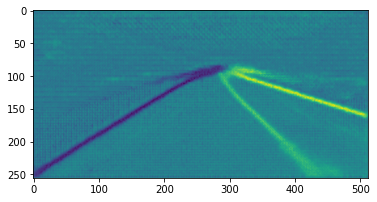

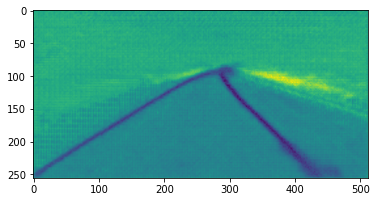

In [68]:
print('pred_emb image type {}'.format(type(pred_emb)))
print('pred_emb image size {}'.format(pred_emb.size()))

pred_emb_ = pred_emb.squeeze().detach().numpy()
plt.imshow(pred_emb_[0])
plt.show()
plt.imshow(pred_emb_[1])
plt.show()
plt.imshow(pred_emb_[2])
plt.show()
plt.imshow(pred_emb_[3])
plt.show()
plt.imshow(pred_emb_[4])
plt.show()

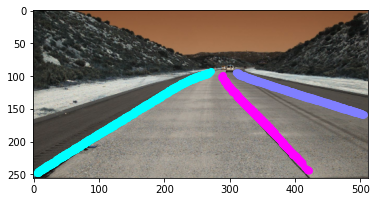

In [69]:
pred_emb__ = np.transpose(pred_emb_, (1, 2, 0))
coords = np.argwhere(binary_mask_)
db = DBSCAN(eps=0.5, min_samples=10).fit(pred_emb__[coords[:,0], coords[:,1], :])
plt.imshow(np.transpose(gt, (1, 2, 0)).numpy().astype(int))
plt.scatter(coords[:,1], coords[:,0], c=db.labels_, cmap='cool')

In [70]:
coords = coords // 4    #(256, 512) --> (64, 128)

In [71]:
H = torch.Tensor([[-2.0484e-01, -1.7122e+01,  3.7991e+02],
                  [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
                  [ 0.0000e+00, -4.6739e-02,  1.0000e+00]])

In [72]:
Y_points = torch.arange(0, 128, 1).to(torch.float32)
Y_points

tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
        108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
        120., 121., 122., 123., 124., 125., 126., 127.])

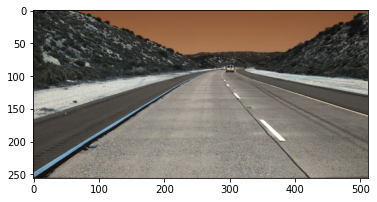

In [91]:
#image = np.transpose(gt, (1, 2, 0)).numpy().astype('float32')
image = np.transpose(gt, (1, 2, 0)).numpy().astype(int)
plt.imshow(image.astype(int))

In [92]:
image = cv2.resize(image.astype('float32'), dsize=(128,64))

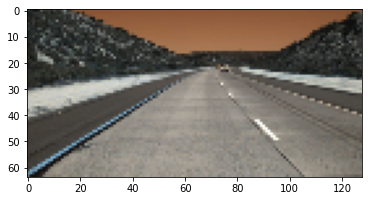

In [93]:
plt.imshow(image.astype(int))

In [131]:
pred_lanes = []
for i in np.unique(db.labels_):
    #print(i)
    pts = torch.Tensor(coords[db.labels_ == i]).to(torch.float32)
    #print(pts)
    ones = torch.ones(pts.size(0),1)
    #print(ones)

        #Y_stack = torch.stack((torch.pow(Y, 3), torch.pow(Y, 2), Y, Y_One), dim=1).squeeze()

    pts = torch.cat((pts, ones), dim=1)
    #print(pts)
    pts_projects = torch.matmul(H, pts.t())
    #print(pts_projects)
    Y = pts_projects[1, :]
    X = pts_projects[0, :]
    #print(Y)
    #print(X)
    Y_One = torch.ones(Y.size())
    #Y_stack = torch.stack((torch.pow(Y, 3), torch.pow(Y, 2), Y, Y_One), dim=1).squeeze()
    Y_stack = torch.stack((torch.pow(Y, 2), Y, Y_One), dim=1).squeeze()
    w = torch.matmul(torch.pinverse(Y_stack), X.view(-1, 1))
    x_preds = torch.matmul(Y_stack, w)
    preds = torch.stack((x_preds.squeeze(), Y, Y_One), dim=1).t()
    pred_lanes.append(preds)

In [135]:
pred_lanes[0]

tensor([[-788.8766, -771.8643, -754.8525,  ...,  333.0957,  350.0822,
          333.0957],
        [-783.2120, -766.2430, -749.2740,  ...,  336.7420,  353.7110,
          336.7420],
        [   1.0000,    1.0000,    1.0000,  ...,    1.0000,    1.0000,
            1.0000]])

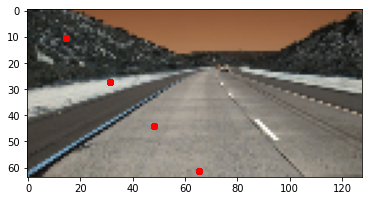

In [143]:
colors = ['red', 'green', 'blue', 'yellow', 'magenta', 'cyan']
plt.imshow(image.astype(int))

for i,lane in enumerate(pred_lanes):
    X = lane[1, :][((0 < lane[1, :]) & (lane[1, :] < 128) & (0 < lane[0, :]) & (lane[0, :] < 64))]
    Y = lane[0, :][((0 < lane[1, :]) & (lane[1, :] < 128) & (0 < lane[0, :]) & (lane[0, :] < 64))]

    plt.scatter(X, Y, c=colors[i], marker='o')

Complete Pipeline

Now you need to implement a class that takes image and a set of  𝑦  coordinates as an input and returns the  𝑥  coordinate for each lane in this image.
It should contain the following steps:
Apply segmentation network to the image
Run DBSCAN over the embeddings for those pixels that are lanes.
Apply h-net to the image
Project pixel coordinates with the predicted homograpgy
Fit the 3-rd order polynomial
Predict the lane position for each provided  𝑦  (you should project this first).
Compute back projection and return the positions of  𝑥  for each lane.
Note: if you weren't able to train the H-Net, you can use the fixed homography here.

In [ ]:
class LaneDetector:
    def __init__(self, hnet, lanenet):
        self.hnet = hnet
        self.lanenet = lanenet
        self.H = torch.Tensor([[-2.0484e-01, -1.7122e+01,  3.7991e+02],
                               [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
                               [ 0.0000e+00, -4.6739e-02,  1.0000e+00]])
        self.resize_for_lanenet = A.Compose([A.Resize(*DEFAULT_SIZE)])
  
    def __call__(self, image, y_positions):
        image = np.array(image)
        image_lanenet = torch.Tensor(self.resize_for_lanenet(image=image)['image'].astype(np.float32))
        image_lanenet = image_lanenet.permute(2,0,1).unsqueeze(0).device()

        binary_seg, instance_emb = self.lanenet(image_lanenet)
        binary_seg = binary_seg.squeeze().detach().cpu().numpy()
        instance_emb = instance_emb.squeeze().permute(1,2,0).detach().cpu().numpy()
        #H = self.hnet(image)
        H = self.H
        coords = np.argwhere(binary_seg > 0.15)
        db = DBSCAN(eps=0.5, min_samples=10).fit(instance_emb[coords[:,0], coords[:,1], :])
        coords = coords // 4
        pred_lanes = []
        for i in range(np.max(db.labels_)+1):
           pass

        return pred_lanes

In [ ]:
#part2 - homography prediction

In [28]:
HNET_DEFAULT_SIZE = (64, 128)

class HomographyPredictionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=True, size=HNET_DEFAULT_SIZE):
        self.dataset_path = dataset_path
        self.size = size
        self.images = []
        self.lanes = []
        self.h_samples = []
        for json_file in os.listdir(self.dataset_path):
            if not json_file.endswith('.json'):
                continue
            json_file_path = os.path.join(self.dataset_path, json_file)
            with open(json_file_path, 'r') as file:
                for line in file:
                    gt = json.loads(line)
                    lanes = gt['lanes']
                    h_samples = gt['h_samples']
                    raw_file= gt['raw_file']
                    image_path = os.path.join(self.dataset_path, raw_file)
                    self.images.append(image_path)
                    self.lanes.append(lanes)
                    self.h_samples.append(h_samples)
                    #gt_trajectory = [[(x, y) for (x, y) in zip(h_samples, lane) if x >= 0] for lane in lanes]
                    #self.ground_truth_trajectory.append(gt_trajectory)
        # train/test split
        if train:
            self.images = self.images[:int(len(self.images) * 0.8)]
            self.lanes = self.lanes[:int(len(self.lanes) * 0.8)]
            self.h_samples = self.h_samples[:int(len(self.h_samples) * 0.8)]
        else:
            self.images = self.images[int(len(self.images) * 0.8):]
            self.lanes = self.lanes[int(len(self.lanes) * 0.8):]
            self.h_samples = self.h_samples[int(len(self.h_samples) * 0.8):]

    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx], cv2.IMREAD_COLOR)
        resize_coef_x = self.size[1] / image.shape[1]
        resize_coef_y = self.size[0] / image.shape[0]
        lanes = self.lanes[idx]
        h_samples = self.h_samples[idx]
        #ground_truth_trajectory = torch.zeros(self.size).permute(1,0)
        #for i, lane in enumerate(lanes):
         #   for x, y in zip(lane, h_samples):
          #      if x >= 0:
           #         x = int(x * resize_coef_x)
            #        y = int(y * resize_coef_y)
             #       ground_truth_trajectory[(x,y)] = i
        #ground_truth_trajectory = ground_truth_trajectory.to(torch.int64)
        #ground_truth_trajectory = [[(int(x * resize_coef_x), int(y * resize_coef_y)) for (x, y) in zip(lane, h_samples) if x >= 0] for lane in lanes]
        ground_truth_trajectory = [[[int(x * resize_coef_x) for (x, y) in zip(lane, h_samples) if x >= 0], [int(y * resize_coef_y) for (x, y) in zip(lane, h_samples) if x >= 0]] for lane in lanes]        
        for i in range(5 - len(ground_truth_trajectory)):
            ground_truth_trajectory.append([])
        image = cv2.resize(image, (self.size[1], self.size[0]))
        image_tensor = torch.tensor(np.transpose(image, (2, 0, 1)), dtype=torch.float)
        return image_tensor, ground_truth_trajectory, image

    def __len__(self):
        return len(self.images)

In [106]:
dataset_path = '/data/tusimple/'

hnet_train_set = HomographyPredictionDataset(dataset_path, train=True)
hnet_val_set = HomographyPredictionDataset(dataset_path, train=False)

idx: 230
image type <class 'numpy.ndarray'>
image shape (64, 128, 3)
5


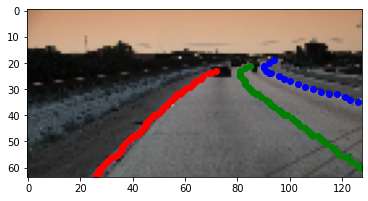

In [110]:
# Choice a random index to get the corresponding sample image, binary lane image, instance lane image
idx = random.randint(0, len(hnet_train_set))
print('idx:', idx)
_, gt_trajectory, image = hnet_train_set[idx]

plt.imshow(image)
colors = ['red', 'green', 'blue', 'yellow', 'magenta', 'cyan']
for i, line in enumerate(gt_trajectory):  
    if len(line) > 0:
        x = line[0]
        y = line[1]
        #x = [x for x,y in line]
        #y = [y for x,y in line]
        plt.scatter(x, y, c=colors[i])
plt.show
print('image type {}'.format(type(image)))
print('image shape {}'.format(image.shape))

In [89]:
# important note: this homography matrix is suitable only for 64x128 resolution
R = torch.Tensor([[-2.0484e-01, -1.7122e+01,  3.7991e+02],
                  [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
                  [ 0.0000e+00, -4.6739e-02,  1.0000e+00]])
R_np = R.numpy()

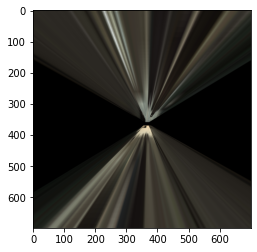

In [90]:
plt.imshow(cv2.warpPerspective(image, R_np, dsize=(700, 700)))

In [54]:
!wget https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg

--2021-10-03 14:21:23--  https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg
Resolving miro.medium.com (miro.medium.com)... 162.159.152.4, 162.159.153.4, 2606:4700:7::a29f:9804, ...
Connecting to miro.medium.com (miro.medium.com)|162.159.152.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136321 (133K) [image/jpeg]
Saving to: ‘1*b3HiwPg69Rw0L5iIMQMXOw.jpeg’

1*b3HiwPg69Rw0L5iIM 100%[===================>] 133.13K  --.-KB/s    in 0.009s  

2021-10-03 14:21:23 (14.6 MB/s) - ‘1*b3HiwPg69Rw0L5iIMQMXOw.jpeg’ saved [136321/136321]



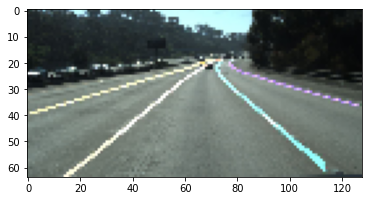

In [139]:
image = plt.imread('1*b3HiwPg69Rw0L5iIMQMXOw.jpeg')
image = cv2.resize(image, (128, 64))
plt.imshow(image)

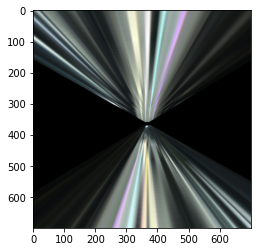

In [141]:
plt.imshow(cv2.warpPerspective(image, R_np, dsize=(700, 700)))

In [91]:
class HNet(nn.Module):
    def __init__(self):
        super(HNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.ln1 = nn.Linear(8192, 1024)
        self.ln2 = nn.Linear(1024, 6)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        Args: x input tensor
        Outputs:
            Coefficents of the transformation matrix (6 numbers)
        """
        x = self.conv1(x)
        x = self.relu(self.bn1(x))
        x = self.conv2(x)
        x = self.relu(self.bn2(x))
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(self.bn3(x))
        x = self.conv4(x)
        x = self.relu(self.bn4(x))
        x = self.maxpool(x)
        x = self.conv5(x)
        x = self.relu(self.bn5(x))
        x = self.conv6(x)
        x = self.relu(self.bn6(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.ln1(x))
        x = self.ln2(x)
        #x = (self.sigmoid(x) - 0.5)  # restrict to a range from -0.5 to 0.5
        return x

In [ ]:
"""
class HomographyLoss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=True):
        super(HomographyLoss, self).__init__(size_average=size_average)

    def forward(self, input, target):
        # TODO
        pass
"""

In [92]:
class HomographyLoss(torch.nn.modules.loss._Loss):
    def __init__(self, gt_pts, transformation_coefficient, name):
        """
        :param gt_pts: [x, y, 1]
        :param transformation_coeffcient: [[a, b, c], [0, d, e], [0, f, 1]]
        :param name:
        :return: 
        """
        super(HomographyLoss, self).__init__()
        self.gt_pts = gt_pts
        self.transformation_coefficient = transformation_coefficient
        self.name = name

    def _hnet_loss(self):
        """
        :return:
        """
        H, preds = self._hnet()
        x_transformation_back = torch.matmul(torch.inverse(H), preds)
        loss = torch.mean(torch.pow(self.gt_pts.t()[0, :] - x_transformation_back[0, :], 2))
        return loss

    def _hnet(self):
        """
        :return:
        """
        one = torch.ones(self.transformation_coefficient.size(0), 1).type_as(self.transformation_coefficient)
        x = torch.cat((self.transformation_coefficient, one), 1)
        index_tensor = torch.tensor([0,1,2,4,5,7,8]).view(1, -1).repeat(self.transformation_coefficient.size(0), 1).type_as(self.transformation_coefficient).long()
        H = torch.zeros(self.transformation_coefficient.size(0), 9).type_as(self.transformation_coefficient).scatter_(1, index_tensor, x).reshape(-1, 3, 3)

        pts_projects = torch.matmul(H, self.gt_pts.t())

        Y = pts_projects[1, :]
        X = pts_projects[0, :]
        Y_One = torch.ones(Y.size())
        #Y_stack = torch.stack((torch.pow(Y, 3), torch.pow(Y, 2), Y, Y_One), dim=1).squeeze()
        Y_stack = torch.stack((torch.pow(Y, 2), Y, Y_One), dim=1).squeeze()
        
        #w = torch.matmul(torch.matmul(torch.inverse(torch.matmul(Y_stack.t(), Y_stack)),
         #                             Y_stack.t()),
          #               X.view(-1, 1))
        w = torch.matmul(torch.pinverse(Y_stack), X.view(-1, 1))
        x_preds = torch.matmul(Y_stack, w)
        preds = torch.stack((x_preds.squeeze(), Y, Y_One), dim=1).t()
        return (H, preds)

    def _hnet_transformation(self):
        H, preds = self._hnet()
        x_transformation_back = torch.matmul(torch.inverse(H), preds)
        return x_transformation_back

    def forward(self, input, target, n_clusters):
        return self._hnet_loss(input, target)

In [111]:
# Define the batch size
batch_size = 10

# Define DataLoaders
hnet_data_loader_train = torch.utils.data.DataLoader(hnet_train_set, batch_size=batch_size, shuffle=True, num_workers=0)
hnet_data_loader_val = torch.utils.data.DataLoader(hnet_val_set, batch_size=1, shuffle=True, num_workers=0)

# Define the learning rate
learning_rate = 5e-5

# Use GPU if available, else use CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [94]:
# Define the model
HNet_model = HNet()
HNet_model.to(device)

# Define the optimizer
params = [p for p in HNet_model.parameters() if p.requires_grad]
#optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=0.0002)
optimizer = torch.optim.SGD(params, lr=learning_rate)

# Define scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Define number of epochs
num_epochs = 10

# Define the loss function
#loss_fn = HomographyLoss()

# Define a list to append the losses 
loss_all = []

In [112]:
# Let's train the model
for epoch in range(num_epochs):
    HNet_model.train()
    ts = time.time()
    for iter, batch in enumerate(hnet_data_loader_train):
        input_image = Variable(batch[0]).to(device)
        pts = Variable(batch[1]).to(device)
        
        h = HNet_model(input_image)
        
        #print(h.size())
        one = torch.ones(h.size(0), 1).type_as(h)
        x = torch.cat((h, one), 1)
        index_tensor = torch.tensor([0,1,2,4,5,7,8]).view(1, -1).repeat(h.size(0), 1).type_as(h).long()
        H = torch.zeros(h.size(0), 9).type_as(h).scatter_(1, index_tensor, x).reshape(-1, 3, 3)
        #print(H.size())
        #print(H)
        #pts = torch.cat((pts, torch.ones(pts.size(0), 1, pts.size(2)).type_as(h)), 1)
        ones = torch.ones(1, pts.size(1)).to(device)
        print(pts.size(), ones.size())        
        hpts = torch.cat([pts, ones], dim=0)
        print(H.size(), pts.size())        
        pts_transformed = torch.matmul(H, hpts)

        hnet_loss = HomographyLoss(pts, h, 'loss')
        hnet_loss.to(device)

        loss = hnet_loss._hnet_loss()
        #pts_projects = torch.matmul(h, ground_truth_trajectory.t())
        #Y = pts_projects[1, :]
        #X = pts_projects[0, :]
        #Y_One = torch.ones(Y.size())
        #Y_stack = torch.stack((torch.pow(Y, 3), torch.pow(Y, 2), Y, Y_One), dim=1).squeeze()
        #Y_stack = torch.stack((torch.pow(Y, 2), Y, Y_One), dim=1).squeeze()
        #w = torch.matmul(torch.pinverse(Y_stack), X.view(-1, 1))
        #x_preds = torch.matmul(Y_stack, w)
        #preds = torch.stack((x_preds.squeeze(), Y, Y_One), dim=1).t()
        #x_transformation_back = torch.matmul(torch.inverse(H), preds)
        #loss = torch.mean(torch.pow(self.gt_pts.t()[0, :] - x_transformation_back[0, :], 2))
        #loss = loss_fn(input, target)   

        optimizer.zero_grad()
        loss_all.append(loss.item())
        loss.backward()
        optimizer.step()
        
        if iter % 20 == 0:
            print("Epoch {} Iteration {} HNet Loss: {}".format(epoch, iter, hnet_loss))
    lr_scheduler.step()
    print("Epoch {} finished! Time elapsed {} ".format(epoch, time.time() - ts))
    torch.save(HNet_model.state_dict(), f"/data/tusimple/lanenet_epoch_{epoch}_batch_size_{batch_size}.model")

# Plot the loss
import matplotlib.pylab as plt
plt.plot(loss_all)

RuntimeError: ignored

In [150]:
#test_hnet():
gt_labels = torch.tensor([[[1.0, 1.0, 1.0], [2.0, 2.0, 1.0], [3.0, 3.0, 1.0]],
                          [[1.0, 1.0, 1.0], [2.0, 2.0, 1.0], [3.0, 3.0, 1.0]]],
                          dtype=torch.float32).view(6,3)
transformation_coffecient = torch.tensor([0.58348501, -0.79861236, 2.30343866,
                                            -0.09976104, -1.22268307, 2.43086767],
                                          dtype=torch.float32)

hnet_loss = HNetLoss(gt_labels, transformation_coffecient, 'loss')
hnet_inference = HNetLoss(gt_labels, transformation_coffecient, 'inference')

_loss = hnet_loss._hnet_loss()
_pred = hnet_inference._hnet_transformation()
print("loss: ", _loss.item())
print("pred: ", _pred)

loss:  14.283940315246582
pred:  tensor([[-0.7495, -1.4991, -2.2486, -0.7495, -1.4991, -2.2486],
        [-0.0347, -0.0695, -0.1042, -0.0347, -0.0695, -0.1042],
        [ 1.0844,  1.1689,  1.2533,  1.0844,  1.1689,  1.2533]])


Finally, we need to implement the loss to fit the network. This is the most difficult part of the project. Homography loss should do the following:

1. Project ground truth trajectory to the new plane according to the homography to obtain $(x', y')$.
2. Perform polynomial fitting $x' = f(y')$. Your code should work correctly with 2-nd and 3-rd order polynomials. Polynomial fitting should be done with the closed-form solution: $w = (Y^TY)^{-1}Y^Tx$ to be able to pass a gradient through. 
3. Compute back projection with the inverse homography.
4. Compute loss between back projected $\hat{x}$ and ground truth $x$.

The full description can be found in the [LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

**IMPORTANT NOTES**

* To fit the polynomial you need to compute the inverse matrix. Computation of the inverse is computation unstable operation. With the help of the SVD you can compute pseudo-inverse matrix: $(X^TX)^{-1}X^T$. In torch this function is called `torch.pinverse`.
* After projection use of the raw $y'$ can be impractical. The features for the polynomial fitting could have a high correlation and therefore solution can be unstable. At first, you need to map $y'$ to some fixed size segment and only then perform a fit.
* After projection some points can occur on the other side of image (bottom part of the projection in the example above). You may want to exclude them, because otherwise polynomial is not going to have much sense and gradients can have a dramatically large values. Positive $w$ in homogeneous coordinates indicates that point is on the wrong side.
* If use the homography provided above, your ground truth should have the same scale, as an image
* Every division in your network is a potential place to obtain `nan` in gradients. Use the following trick to obtain less divisions:
after computing the projection, remember the $w$. Then, before the back projection, multiply your vector by $w$. After back projection you will see that $w$ is equal to 1. So you don't need to devide your vector by $w$.
* You correction to the initial homography could be very big and can completely spoil the homography. So you may need to scale the output of the last layer in the HNet to obtain a smaller corrections.
